<a href="https://colab.research.google.com/github/MhmdSafa7/Chest_disease_DL/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks"


chest_xray  main.ipynb


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/chest_xray/train"

NORMAL	PNEUMONIA


In [5]:


train_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test'
base_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print("Classes:", os.listdir(train_dir))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: ['PNEUMONIA', 'NORMAL']


In [6]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')




In [7]:
for split in ['train', 'val', 'test']:
    path = os.path.join(base_dir, split)
    classes = os.listdir(path)
    print(f"\n📂 {split.upper()} set:")

    for c in classes:
        class_path = os.path.join(path, c)
        if not os.path.isdir(class_path):   # 👈 skip files like .DS_Store
            continue
        count = len(os.listdir(class_path))
        print(f"  {c:10s}: {count} images")





📂 TRAIN set:
  PNEUMONIA : 3875 images
  NORMAL    : 1341 images

📂 VAL set:
  PNEUMONIA : 8 images
  NORMAL    : 8 images

📂 TEST set:
  PNEUMONIA : 390 images
  NORMAL    : 234 images


In [8]:
!find /content/drive/MyDrive/Colab\ Notebooks/chest_xray -name ".DS_Store" -delete



🩻 Sample images for PNEUMONIA:


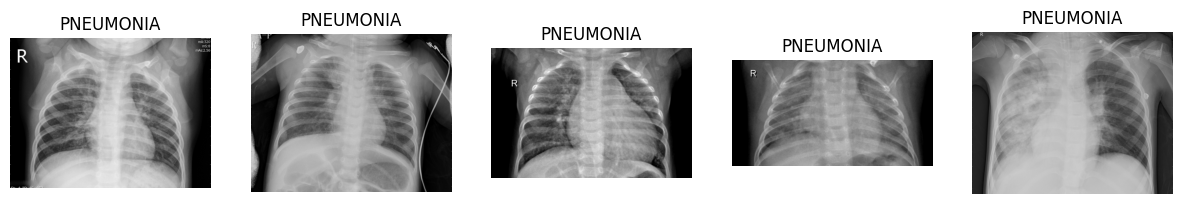


🩻 Sample images for NORMAL:


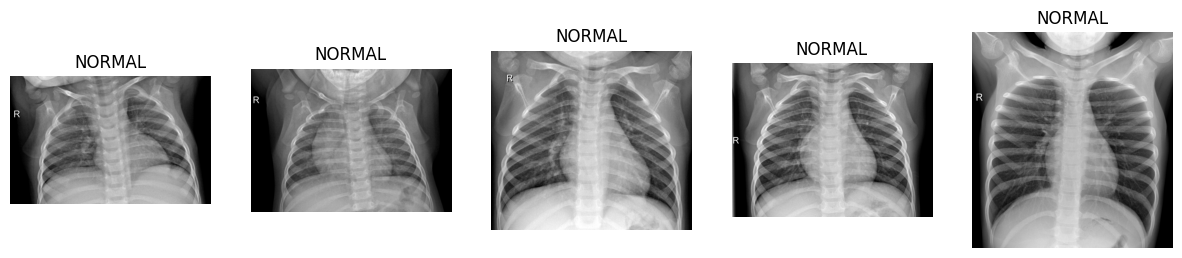

In [9]:
def show_random_images(folder, n=5):
    plt.figure(figsize=(15,5))
    images = os.listdir(folder)
    for i in range(n):
        img_path = os.path.join(folder, random.choice(images))
        img = plt.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(folder))
        plt.axis('off')
    plt.show()

# Show examples from each class
for category in os.listdir(train_dir):
    print(f"\n🩻 Sample images for {category}:")
    show_random_images(os.path.join(train_dir, category))


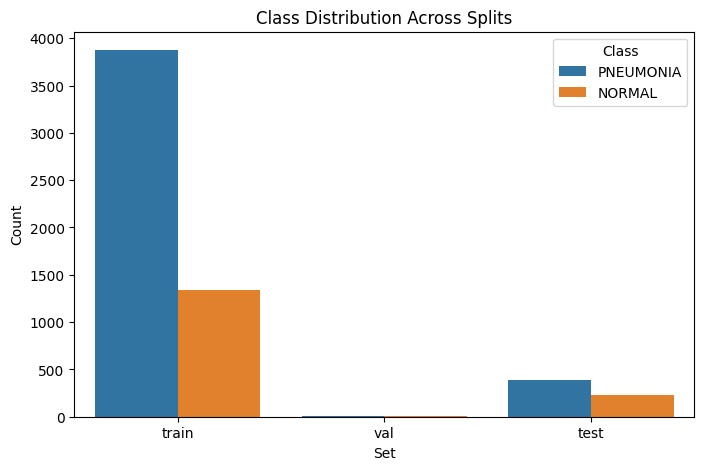

In [10]:
counts = []
for split in ['train', 'val', 'test']:
    for c in os.listdir(os.path.join(base_dir, split)):
        count = len(os.listdir(os.path.join(base_dir, split, c)))
        counts.append({'Set': split, 'Class': c, 'Count': count})

df = pd.DataFrame(counts)
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Set', y='Count', hue='Class')
plt.title('Class Distribution Across Splits')
plt.show()

In [11]:


# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values (0–255 → 0–1)
    rotation_range=20,            # Random rotation
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    shear_range=0.2,              # Shear transform
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip horizontally
    fill_mode='nearest'           # Fill empty pixels
)

# Validation and test data (only normalization)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test'


In [12]:
IMG_SIZE = 224  # or 150

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # resize images
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


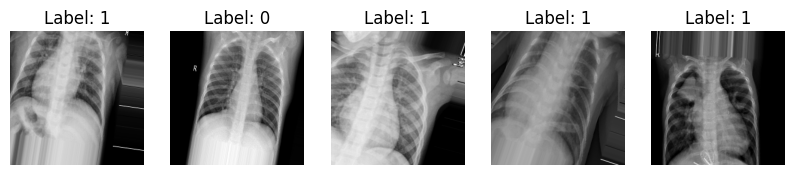

In [13]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.show()

In [14]:
IMG_SIZE = 224  # must match your generator

model = models.Sequential([
    # 1️⃣ Convolution + Pooling Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    # 2️⃣ Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 3️⃣ Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 4️⃣ Flatten + Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # helps prevent overfitting
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2644s 16s/step - accuracy: 0.7501 - loss: 0.5073 - val_accuracy: 0.6875 - val_loss: 0.6110
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 743ms/step - accuracy: 0.8539 - loss: 0.3381 - val_accuracy: 0.6250 - val_loss: 1.1114
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 755ms/step - accuracy: 0.8651 - loss: 0.3015 - val_accuracy: 0.8125 - val_loss: 0.5023
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 739ms/step - accuracy: 0.8748 - loss: 0.2958 - val_accuracy: 0.6250 - val_loss: 0.9600
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.8900 - loss: 0.2644 - val_accuracy: 0.7500 - val_loss: 0.5351
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 746ms/step - accuracy: 0.9012 - loss: 0.2304 - val_accuracy: 0.8125 - val_loss: 0.4050
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 733ms/step - accuracy: 0.8991 - loss: 0.2465 - val_accuracy: 0.8125 - val_loss: 0.3980
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 731ms/step - accuracy: 0.9073 - 

In [16]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6875 - loss: 0.9422

✅ Validation Accuracy: 0.6875
📉 Validation Loss: 0.9422


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = val_generator.classes

# Labels
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("\n📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step

📈 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


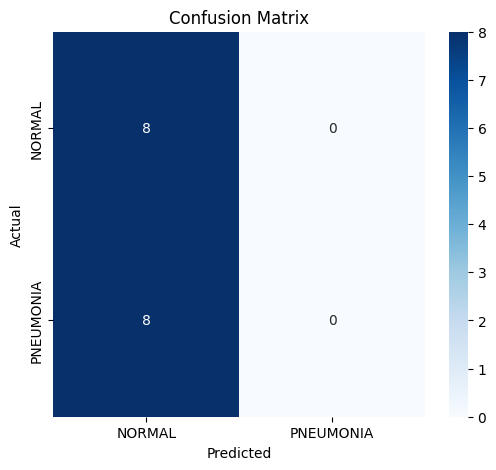

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


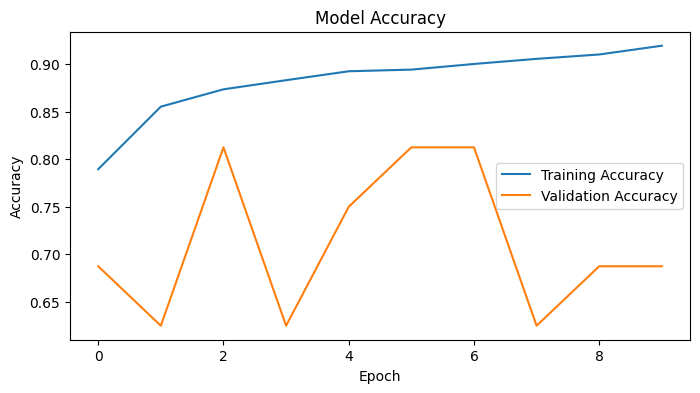

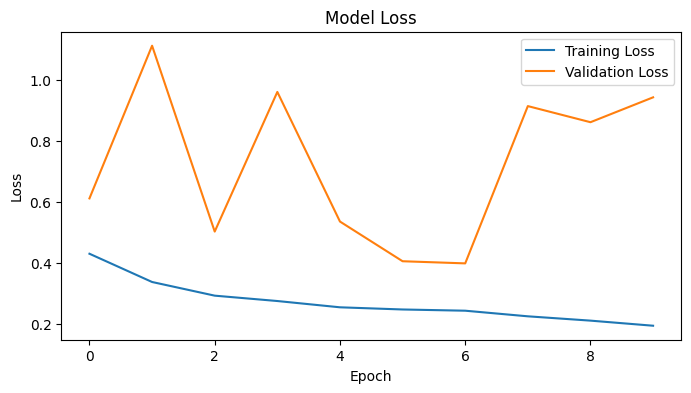

In [19]:
# Plot accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
import os
train_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'

for c in os.listdir(train_dir):
    if not c.startswith('.'):
        print(c, "→", len(os.listdir(os.path.join(train_dir, c))), "images")


PNEUMONIA → 3875 images
NORMAL → 1341 images


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'   # 👈 THIS is key
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'   # 👈 same here
)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [28]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 803ms/step - accuracy: 0.8785 - loss: 0.3213 - val_accuracy: 0.8750 - val_loss: 0.2498
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 724ms/step - accuracy: 0.9360 - loss: 0.1463 - val_accuracy: 0.9375 - val_loss: 0.1973
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9433 - loss: 0.1414 - val_accuracy: 0.8750 - val_loss: 0.2634
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9524 - loss: 0.1229 - val_accuracy: 0.8125 - val_loss: 0.2421
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 721ms/step - accuracy: 0.9525 - loss: 0.1149 - val_accuracy: 0.8750 - val_loss: 0.2148
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 728ms/step - accuracy: 0.9609 - loss: 0.1037 - val_accuracy: 0.8750 - val_loss: 0.1985
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.9544 - loss: 0.1143 - val_accuracy: 0.9375 - val_loss: 0.1961
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 708ms/step - accuracy: 0.9546 -

In [29]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8750 - loss: 0.2258
Validation Accuracy: 0.8750
Validation Loss: 0.2258


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


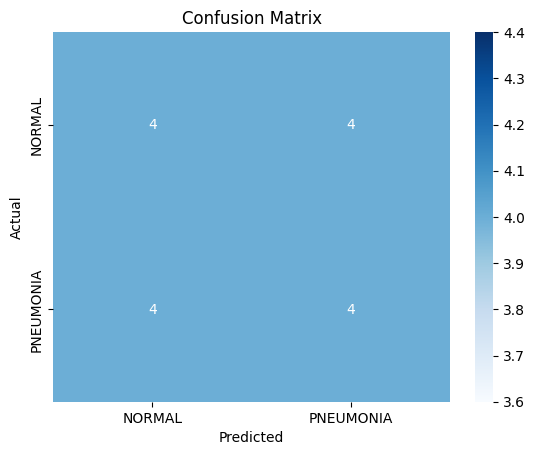


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      0.50      0.50         8
   PNEUMONIA       0.50      0.50      0.50         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.50        16
weighted avg       0.50      0.50      0.50        16



In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_probs = model.predict(val_generator, verbose=1)

# Convert to binary labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Get true labels
y_true = val_generator.classes

# ⚠️ Fix: make sure lengths match
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(val_generator.class_indices.keys()),
            yticklabels=list(val_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))
